In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import csv
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
import sklearn.preprocessing as skl
from PIL import Image, ImageOps
from os import listdir
from os.path import isfile, join

plt.ion()

Using TensorFlow backend.


In [2]:
# Per importar variables i no haver de fer el predict(), en el cas de que les tinguem guardades i volguem tornar a executar el programa amb la mateixa capa
import pickle
f1 = open('sortidaavg.pckl', 'rb')
sortida=pickle.load(f1)
f1.close()
f2 = open('sortidaavg2.pckl', 'rb')
sortida2=pickle.load(f2)
f2.close()

In [3]:
#Escollim quina xarxa utilitzarem
base_model = ResNet50(weights='imagenet')

In [ ]:
# Esquema informatiu de les capes del model
base_model.summary()

In [4]:
#Definim quina capa de la xarxa utilitzarem
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

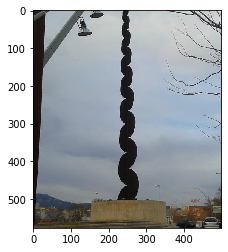

In [5]:
database = [f for f in listdir("./TB2019_2020/database/database") if isfile(join("./TB2019_2020/database/database", f))]    # Guardem a una llista tots els fitxer d'imatges que haurem de llegir
train = np.array([np.array(Image.open("./TB2019_2020/database/database/" + fname)) for fname in database])                  # Llegim totes les imatges a una variable matriu (3D)

queries = [f for f in listdir("./TB2019_2020/queries/queries") if isfile(join("./TB2019_2020/queries/queries", f))]         # Guardem a una llista tots els fitxer d'imatges que haurem de llegir
test = np.array([np.array(Image.open("./TB2019_2020/queries/queries/" + fname)) for fname in queries])                      # Llegim totes les imatges a una variable matriu (3D)

# Provem que se'ns hagin guardat les imatges
plt.figure()                              # Obrir figura per representar imatge
imatge = plt.imshow(test[1], cmap='gray') # Mostrar imatge a la figura oberta

In [6]:
# Creem dos vectors amb el nom de les imatges sense l'extensió '.jpg' per tal de, més endevant, poder crear el fitxer .csv
database_d = []
queries_q=[]
for l in range (len(database)):
    database_d.append(database[l][0:10])
    
for m in range (len(queries)):
    queries_q.append(queries[m][0:10])

In [7]:
#IMATGES QUERIES
i=0
imatge = []
final = []
for i in range(len(queries)):
    imatge.append(image.load_img('./TB2019_2020/queries/queries/'+queries[i], target_size=(224,224))) # Afegim les imatges de queries al vector imatge []
    final.append(image.img_to_array(imatge[i])) # Afegim a final [] la imatge com un array
    final[i] = np.expand_dims(final[i], axis=0)
    final[i] = preprocess_input(final[i])

In [11]:
sortida = [] 
k = 0
for k in range(len(queries)):
    sortida.append(model.predict(final[k])) # Predicció entre el model i el vector amb les imatges de queries

In [10]:
#IMATGES DATABASE
i2=0
imatge2=[]
final2=[]
for i2 in range(len(database)):
    imatge2.append(image.load_img('./TB2019_2020/database/database/' + database[i2], target_size=(224,224))) # Afegim les imatges de database al vector imatge []
    final2.append(image.img_to_array(imatge2[i2])) # Afegim a final [] la imatge com un array
    final2[i2]=np.expand_dims(final2[i2],axis=0)
    final2[i2]=preprocess_input(final2[i2])

In [14]:
sortida2=[]
k2 = 0
for k2 in range(len(database)):
    sortida2.append(model.predict(final2[k2])) # Predicció entre el model i el vector amb les imatges de database

In [15]:
# Exportar variables del predict(). Només executar la primera vegada que provem el codi.
import pickle
f1=open('sortidaavg.pckl', 'wb')
pickle.dump(sortida, f1)
f1.close()

f2=open('sortidaavg2.pckl', 'wb')
pickle.dump(sortida2, f2)
f2.close()

In [11]:
descriptor = np.asarray(sortida) # Convertim sortida a un array

In [12]:
descriptor2 = np.asarray(sortida2) # Convertim sortida2 a un array

In [13]:
descriptor.shape

(2065, 1, 2048)

In [14]:
descriptor2.shape

(2061, 1, 2048)

In [15]:
descriptors_test = np.reshape(descriptor,(2065,2048))
descriptors_train = np.reshape(descriptor2,(2061,2048))

In [16]:
# Normalitzem els dos descriptors...
x_train_normalized = skl.normalize(descriptors_train, norm='l2', axis=1, copy=True, return_norm=False)
x_test_normalized = skl.normalize(descriptors_test, norm='l2', axis=1, copy=True, return_norm=False)

In [17]:
# ... i transposem el de train
x_train_normalized = x_train_normalized.transpose()

In [18]:
# Calculem la convolució per tal de trobar les similituts
similarities = np.matmul(x_test_normalized,x_train_normalized)

In [19]:
# Ordenem el vector de similarities per tal de crear un rànquing
ranks = np.argsort(similarities, axis=1)[:,::-1]

In [20]:
x_test_imatges = []
x_train_imatges = []

In [21]:
v = 0
for v in range(2065): 
    x_test_imatges.append(np.array(imatge[v]))
    

In [22]:
b = 0
for b in range(2061): 
    x_train_imatges.append(np.array(imatge2[b]))
    

In [23]:
h,w = (224, 224)
new_image=Image.new('RGB', (h*5,w*13))

In [24]:
# Visualitzem el resultats de deiferents imatges de queries
offset = 10
for q in range(13):
  ranks_q = ranks[q*(offset+1),:]
  for i in range(4):
      new_image.paste(Image.fromarray(x_train_imatges[ranks_q[i]]), (h*(1+i),w*q))

      ima_q = Image.fromarray(x_test_imatges[q*(offset+1)])
      ima_q = ImageOps.expand(ima_q, border=20, fill='red')

      new_image.paste(ima_q, (0,w*q))
      

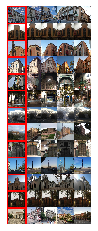

In [25]:
# Mostrem la imatge final
plt.imshow(new_image)
plt.axis('off')
plt.show()

In [34]:
# Definim la primera fila del fitxer .csv
csv1=[]
row1=["Query", "RetrievedDocuments"]

In [35]:
for q in range (2065): #Imatges QUERIES que tenim
    ranks_q = ranks[q,:]
    csv2 = []
    csv2.append(queries_q[q])
    name=''
    for i in range (1, 2061): #Imatges DATABASE que tenim. Comencem del 1 perquè la posició 0 ens surt una imatge que no correspon.         
        if i == 2061:
            name = name + ' ' + database_d[ranks_q[0]]
            name = name + '\n'
        else:
            name = name + ' ' + database_d[ranks_q[i]]
    csv2.append(name)
    csv1.append(csv2)
    

In [36]:
with open("RankingAVGX_Equip2.csv",'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(row1)
    for z in range(2065):
        wr.writerow(csv1[z]) # Emplenem totes les files del fitxer .csv